## The grid cell system model is a spiking neural network (SNN) model written in pyNEST (2.18)
@author R Stentiford

In this experiment a grid cell attractor network is built using interactions between and excitatory and inhibitory population. Four conjunctive layers driven by the translational velocity drive the activity bump across the sheet

Spikes and figures are saved to the folder containing the data, in a folder spcified by the current time - figures and params are saved when testing different parameters

In [10]:
folder = 'rat_data_test_run'

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import nest as sim
import numpy as np
import pandas
from collections import Counter
import time as tm
import scipy.stats
from scipy.io import loadmat
import pandas as pd
from datetime import datetime
import os
import grid_analysis as griddy

sim.ResetKernel()

mins = 20.
sim_len = int(mins * 60000)
print(f'simulation length: {mins} mins = {sim_len} ms')

In [12]:
# save folder based on current time
tic = tm.time()
txt = str(datetime.now())
spl = txt.split(' ')
spl2 = spl[1].split('.')
spl2 = spl2[0].replace(':','-')
txt = f'{spl[0]}_{spl2}'
file = f'{txt}_spikes'
chunk = 600000
path = f'data/{folder}/{txt}_PCN'
os.makedirs(path)
print(path)

sim.SetKernelStatus({"overwrite_files": True,"data_path": path,"data_prefix": txt})

data/rat_data_test_run/2022-05-27_11-25-31


In [4]:
y_dim = (0.5* np.sqrt(3))
Nx = 20
Ny = int(np.ceil(Nx * y_dim))
N = Nx * Ny

sigma = 0.5/6 #0.12
mu = 0.5
delay = 0.1
base_ex = 4000
base_in = 450
base_cj = 3500. #THIS PARAMETER WILL CHANGE THE GRID SCALE
w_ex_cj = 500.

I_init = 300.0 #pA
I_init_dur = 100.0 #ms
I_init_pos = 0

# these parameters control how the velocity maps to current
gain = 1000
sh = 500
pred_gain = 2000

# these parameters control the artifical grid input
grid_space = 70 #cm
grid_phase = 0
grids = {}
spacex = grid_space/Nx
spacey = grid_space/Ny

### Create populations

All cells are simulated using pyNEST's standard leaky integrate-and-fire neuron model (iaf_psc_alpha) which uses alpha-function shaped synaptic currents. 

The network is composed of six equally sized rings of neurons: 180 excitatory cells, 180 excitatory cells, 180 of each up, down, left and right conjunctive cells. 

Constant input current of 400 pA to all excitatory neurons results in spontaneous firing.

In [5]:
exc = sim.Create("iaf_psc_alpha",N, params={"I_e": 400.})
inh = sim.Create("iaf_psc_alpha",N)

l = sim.Create("iaf_psc_alpha",N)
r = sim.Create("iaf_psc_alpha",N)
u = sim.Create("iaf_psc_alpha",N)
d = sim.Create("iaf_psc_alpha",N)

### Define connections

Attractor dynamics emerge through reciprocal connections between cells in the excitatory population and inhibitory population. Each excitatory cell connects to a subset of inhibitory neurons with declining synaptic strength as a function of distance. Reciprocal inhibitory connections from each inhibitory cell to excitatory cells are arranged with synaptic strength decreasing as a function of distance offset by a constant (mu).

This arrangement provides inhibitory input to the cells surrounding the most active excitatory cell, producing a single stable bump of activity.

Cells are arranged as 2D sheets with twisted torus wrap around connectivity for the purpose of defining synaptic strength based on distance. See Guanella et al 2007 for a full description of this connectivity structure and the origin of the following calculations.

In [4]:
def twistedTorus(x_e,y_e,x_i,y_i,y_dim):
        d1 = np.sqrt(abs(x_e - x_i)**2 + abs(y_e - y_i)**2)
        d2 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d3 = np.sqrt(abs(x_e - x_i - 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d4 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i + y_dim)**2)
        d5 = np.sqrt(abs(x_e - x_i + 0.5)**2 + abs(y_e - y_i - y_dim)**2)
        d6 = np.sqrt(abs(x_e - x_i - 1.)**2 + abs(y_e - y_i)**2)
        d7 = np.sqrt(abs(x_e - x_i + 1.)**2 + abs(y_e - y_i)**2)
        
        return min(d1,d2,d3,d4,d5,d6,d7)

In [5]:
w_ex = np.empty((N,N))
w_in = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = y_dim*(e//Nx)/ Ny
    for i in range(N): 
        x_i = (i%Nx) / Nx 
        y_i = y_dim*(i//Nx) / Ny
        
        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)

        w_gauss = np.exp(-(d_)**2/2/sigma**2)
        w_ring = np.exp(-(d_ - mu)**2/2/sigma**2)

        w_ex[i,e] = base_ex * w_ring
        w_in[e,i] = base_in * w_gauss

w_ex[w_ex<10]=0
w_in[w_in<10]=0

In order to track translaiton based on velocity the four populations of conjunctive cells are connected one to one with an excitatory cell, shifted one cell u, down, left or right on the sheet from the equivalently positioned neuron.

The same distance dependent calculation is performed, using ofset positions of the inhibitory cell, with only the strongest connection maintained. Due to the twisted torus configuration and the ydim parameter this may be more than one cell with lower weights.

In [6]:
w_l = np.empty((N,N))
w_r = np.empty((N,N))
w_u = np.empty((N,N))
w_d = np.empty((N,N))
for e in range(N):
    x_e = (e%Nx) / Nx
    y_e = (e//Nx) / Ny * y_dim
    for i in range(N): 
        x_i = ((i%Nx) / Nx) - (1/Nx) #shift
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_l[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = ((i%Nx) / Nx) + (1/Nx) #shift 
        y_i = (i//Nx) / Ny * y_dim

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_r[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))        

        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) + (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_u[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
        x_i = (i%Nx) / Nx 
        y_i = ((i//Nx) / Ny * y_dim) - (1 / Ny * y_dim)  #shift

        d_ = twistedTorus(x_e,y_e,x_i,y_i,y_dim)
        w_d[i,e] = base_cj * (np.exp(-(d_)**2/2/sigma**2))
        
m = np.amax(w_l)
w_l[w_l<m] = 0
m = np.amax(w_r)
w_r[w_r<m] = 0
m = np.amax(w_u)
w_u[w_u<m] = 0
m = np.amax(w_d)
w_d[w_d<m] = 0

The populations are connected using these calculated weights. 

excitatory cells also connect one to one with the equivalent conjunctive cell in all four populations.

In [6]:
exc_2_inh = sim.Connect(exc,inh,'all_to_all',syn_spec={'weight': w_ex, 'delay': delay})
inh_2_exc = sim.Connect(inh,exc,'all_to_all',syn_spec={'weight': -w_in, 'delay': delay})

exc_2_l = sim.Connect(exc,l,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_r = sim.Connect(exc,r,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_u = sim.Connect(exc,u,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})
exc_2_d = sim.Connect(exc,d,'one_to_one',syn_spec={'weight': w_ex_cj, 'delay': delay})

l_2_exc = sim.Connect(l,exc,'all_to_all',syn_spec={'weight': w_l, 'delay': delay})
r_2_exc = sim.Connect(r,exc,'all_to_all',syn_spec={'weight': w_r, 'delay': delay})
u_2_exc = sim.Connect(u,exc,'all_to_all',syn_spec={'weight': w_u, 'delay': delay})
d_2_exc = sim.Connect(d,exc,'all_to_all',syn_spec={'weight': w_d, 'delay': delay})

### Network input

Translational velocity of the robot is determined by taking the first derivative of the xy position captured from the simulated WhiskEye at a rate of 50 Hz, taking the difference in pose at each time step.

In [2]:
posedata = pandas.read_csv(f'data/{folder}/{folder}.csv')
pos_t = np.array(np.around(posedata['Time']*1000))
print(f'Data length = {pos_t[-1]}ms = {pos_t[-1]/60000}min')
if pos_t[-1]<sim_len: # trunkate simulation length if data is too short
    sim_len = pos_t[-1]
    mins = sim_len/60000
    print(f'simulation length: {mins} mins = {sim_len} ms')

Data length = 1202340.0ms = 20.039min


92.65068759672495


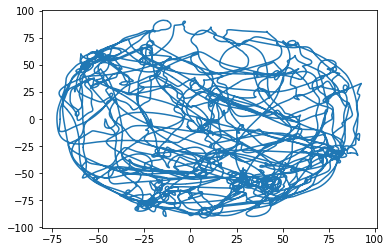

In [3]:
pos_x = np.array(posedata['X']*100) # convert to cm
pos_y = np.array(posedata['Y']*100)

# exclude first 10 datapoints
pos_x = pos_x[10:]
pos_y = pos_y[10:]
pos_t = pos_t[10:]

dt = int(np.average(np.diff(pos_t)))
t = pos_t
time = [i * 1. for i in t if i < sim_len]

plt.plot(pos_x[:len(time)],pos_y[:len(time)])

env_rad = np.max(pos_x)

60107 60106


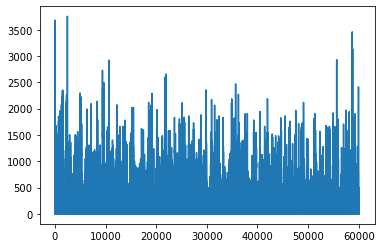

In [9]:
vel_x = np.diff(pos_x)
vel_y = np.diff(pos_y)

vel_x,vel_y = vel_x*gain, vel_y*gain

go_l,go_r = vel_x,-vel_x
go_u,go_d = vel_y,-vel_y
go_l, go_r, go_u, go_d = go_l+sh, go_r+sh, go_u+sh, go_d+sh
go_l[go_l<=sh] = 0.
go_r[go_r<=sh] = 0.
go_u[go_u<=sh] = 0.
go_d[go_d<=sh] = 0.

plt.figure()
plt.plot(go_r)

l_input = sim.Create('step_current_generator', 1)
sim.SetStatus(l_input,{'amplitude_times': t[1:],'amplitude_values': go_l})
r_input = sim.Create('step_current_generator', 1)
sim.SetStatus(r_input,{'amplitude_times': t[1:],'amplitude_values': go_r})
u_input = sim.Create('step_current_generator', 1)
sim.SetStatus(u_input,{'amplitude_times': t[1:],'amplitude_values': go_u})
d_input = sim.Create('step_current_generator', 1)
sim.SetStatus(d_input,{'amplitude_times': t[1:],'amplitude_values': go_d})

In [10]:
sim.Connect(l_input,l,'all_to_all')
sim.Connect(r_input,r,'all_to_all')
sim.Connect(u_input,d,'all_to_all')
sim.Connect(d_input,u,'all_to_all')

## PredNet predictions

In [11]:
grid_cell_input = np.load(f'data/{folder}/reconstructions_grid_cells.npy')
predtm = np.load(f'data/{folder}/test_timestamps.npy')
predidx = np.array(predtm[:,0]).astype(int)
predtms = pos_t[predidx]

start_idx = int(predidx[0])
end_idx = int(predidx[-1])

print(len(pos_x),start_idx,end_idx)

pos_x = pos_x[start_idx:end_idx]
pos_y = pos_y[start_idx:end_idx]
pos_t = pos_t[start_idx:end_idx]

dt = int(np.average(np.diff(pos_t)))
t = pos_t
time = [i * 1. for i in t if i < sim_len]

plt.plot(pos_x,pos_y)

(-100.0, 100.0)

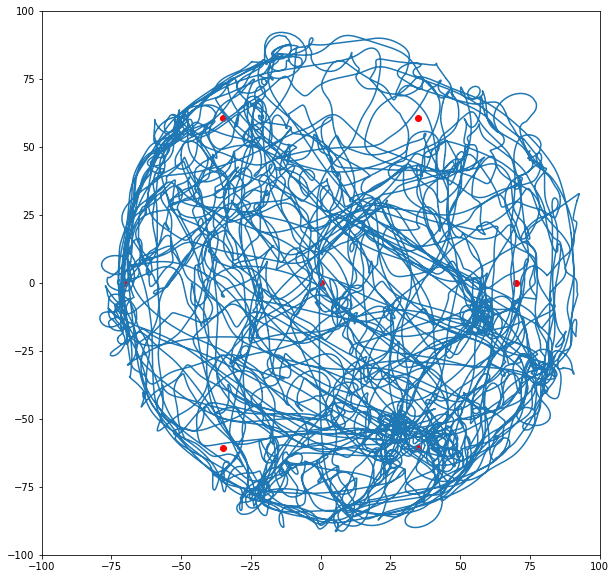

In [12]:
grid_cell_input = grid_cell_input*500
plt.plot(grid_cell_input[20,:])

In [17]:
view_input = sim.Create('step_current_generator', N)
for n in range(N):
    sim.SetStatus([view_input[n]],{'amplitude_times': predtms[1:],'amplitude_values': grid_cell_input[1:,n]})
    
sim.Connect(view_input,exc,'one_to_one')

### Record spikes

In [18]:
exc_spikes = sim.Create("spike_detector", 1, params={"withgid": True,"withtime": True, "to_file": True, "label": "gc_spikes"})
sim.Connect(exc,exc_spikes)

### Init bump

In [19]:
bump_init = sim.Create('step_current_generator', 1, params = {'amplitude_times':[0.1,0.1+I_init_dur],'amplitude_values':[I_init,0.0]})
sim.Connect(bump_init,[exc[216]])

### Run simulation

In [20]:
sim.Simulate(sim_len)
print(f'Starting simulation in {sim_len/chunk} chunks. Saving to {folder}')

sim.Prepare()
for i in np.arange(sim_len/chunk):
    sim.Run(chunk)
    print(f'Chunk {i} complete...')
sim.Cleanup()
print(f'Simulation run time: {np.around(tm.time()-tic,2)}s  Simulated time: {np.around(sim_len/1000,2)}s')

Starting simulation in 1.0 chunks. Saving to rat_600000ms_2022-04-26_20:24:48_gain_2000
Chunk 0.0 complete...
Simulation run time: 5475.85s  Simulated time: 600.0s


In [21]:
for file in os.listdir(path):
    if file.endswith(".gdf"):
        data = pd.read_csv(f'{path}/{file}', delimiter="\t")
        data = data.drop(columns=['Unnamed: 2'])
        data = data.set_axis(['sp','t'], axis=1, inplace=False)
        sp = np.array(data['sp'])
        t = np.array(data['t'])

print(f'Spikes reloaded. Plotting...')

Spikes reloaded. Plotting...


Plot saved rat_600000ms_2022-04-26_20:24:48_gain_2000/spikes.png


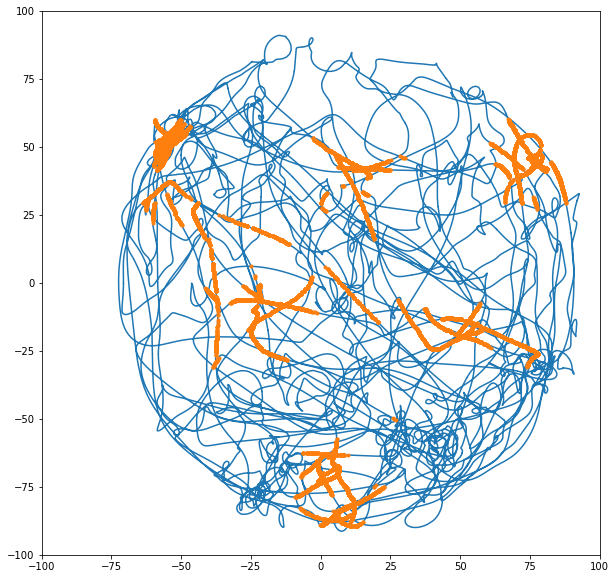

In [31]:
# occurence_count = Counter(sp) 
# # print(occurence_count)
# cell = occurence_count.most_common(5)[0][0]
# print(cell)

cell = 243

spktms = t[sp==cell]
spktms = (spktms//20)*20
spktms=spktms[1:]

xs = np.empty((len(spktms)))
ys = np.empty((len(spktms)))

for i,spk in enumerate(spktms):
    try:
        xs[i] = pos_x[np.where(time == spk)[0][0]]
        ys[i] = pos_y[np.where(time == spk)[0][0]]
    except:
        a=1

fig = plt.figure(figsize=(10, 10),facecolor='w')
plt.plot(pos_x[:len(time)],pos_y[:len(time)])
plt.plot(xs,ys,'.')
plt.xlim([-100,100])
plt.ylim([-100,100])

plt.savefig(f'{path}/spikes.png')

print(f'Plot saved {path}/spikes.png')

In [ ]:
dictparams = {'gain': gain, 
              'sh':sh, 
              'base_cj':base_cj, 
              'Nx':Nx, 
              'Ny':Ny, 
              'sigma':sigma, 
              'mu':mu, 
              'delay':delay, 
              'base_ex':base_ex, 
              'base_in':base_in,
              'w_ex_cj':w_ex_cj,
              'y_dim':y_dim,
              'pred_gain':pred_gain,
              'grid_space':grid_space,
              'grid_phase':grid_phase
             }

np.save(f'{path}/params',dictparams)

In [32]:
prm = dict()
prm['pixel_ratio'] = 440
prm['output_path'] = f'{path}/'

In [33]:
spike_data = pd.DataFrame()

cells = [cell]
for cell in cells: #set(sp):
    spktms = t[sp==cell]
    spktms = (spktms//20)*20

    xs = np.empty((len(spktms)))
    ys = np.empty((len(spktms)))

    for i,spk in enumerate(spktms):
        if spk < 60000:
            xs[i] = pos_x[np.where(time == spk)[0][0]]
            ys[i] = pos_y[np.where(time == spk)[0][0]]

    spike_data = spike_data.append({'cell_id': int(cell),
                                    'spike_times': spktms, 
                                    'number_of_spikes': len(spktms),
                                    'mean_firing_rate': len(spktms)/(sim_len/1000),
                                    'position_x': xs - min(pos_x),
                                    'position_y': ys - min(pos_y),
                                    'position_x_pixels' : (xs - min(pos_x)) / 100 * prm['pixel_ratio'],
                                    'position_y_pixels' : (ys - min(pos_y)) / 100 * prm['pixel_ratio']
                                    }, ignore_index=True)

spike_data.to_pickle(f'{path}/spike_data.pkl')

In [34]:
spatial_data = dict()
spatial_data['position_x'] = pos_x - min(pos_x)
spatial_data['position_y'] = pos_y - min(pos_y)

# pixels = cm / 100 * prm['pixel_ratio']
spatial_data['position_x_pixels'] = spatial_data['position_x'] / 100 * prm['pixel_ratio']
spatial_data['position_y_pixels'] = spatial_data['position_y'] / 100 * prm['pixel_ratio']

spatial_data = pd.DataFrame.from_dict(spatial_data)
spatial_data.to_pickle(f'{path}/spatial_data.pkl')

I will plot a heat map of the position of the animal to show coverage.


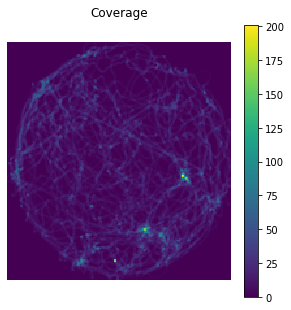

In [35]:
position_heat_map = griddy.get_position_heatmap(spatial_data, prm)
griddy.plot_coverage(position_heat_map, prm)

In [36]:
if not 'firing_maps' in spike_data:
    position_heat_map, spike_data = griddy.make_firing_field_maps(spatial_data, spike_data, prm)

I will calculate firing rate maps now.
Started another cluster
0
Making the rate maps took:
158.53404116630554


I will make rate map plots.


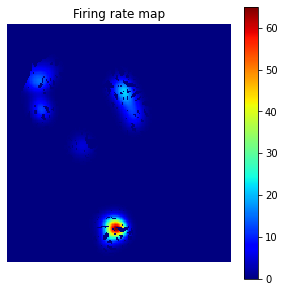

In [37]:
# plot firing rate maps
griddy.plot_firing_rate_maps(spike_data, prm)

In [29]:
spike_data = griddy.process_grid_data(spike_data)
spike_data.to_pickle(f'{path}/spike_data.pkl')

/mnt/c/Users/rsten/Documents/BRL/Projects/attractor-models-HD-grid/Grid/Feb2022/apr22_random_walk/grid_analysis.py:278: RuntimeWarning:invalid value encountered in multiply
